# Homework 1

Homework policy: the homework is individual. Students are encouraged to discuss with fellow students to try to find the main structure of the solution for a problem, especially if they are totally stuck at the beginning of the problem. However, you should work out the details yourself and write down in your own words only what you understand yourself.

## Problem: ML Estimation of Roundtrip Delay Distribution¶

In this problem, we consider the roundtrip delay in a computer network (internet) between the computer we’re working on and another computer connected to the network. This roundtrip delay will be different, every time we send a message. As such, it can be modeled as a random variable y. For the design of network protocols and for their performance evaluation, it is important to know the distribution of this random roundtrip delay. To turn the estimation of the roundtrip delay distribution into a parameter estimation problem, we shall take a parametric distribution, parameterized by one or more parameters. Since we don’t have too much information about this variable y (except that it should be positive), we shall try several parametric distributions. In particular, we shall consider the following distributions:

$$
\begin{gather}
\text { * A Gaussian distribution: } \qquad f_G (y|\mu, \sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}}  e^{-\frac{(y−\mu)^2}{2\sigma^2}} 
\qquad \qquad \qquad \qquad \qquad \qquad 
\\
\text { * A Rayleigh distribution: } \qquad f_R (y|\sigma^2) = 
\begin{cases}
0 & , y < 0
\\
\frac{y}{\sigma^2}  e^{-\frac{y^2}{2\sigma^2}} & , y \geq 0
\end{cases} 
\qquad \qquad \qquad \qquad \qquad \qquad
\end{gather}
$$

In [1]:
using Turing
using StatsPlots

Then, we define a simple Normal model with unknown mean and variance

In [2]:
@model function gdemo(x, ::Type{T} = Float64) where {T}
    if x === missing
        # Initialize `x` if missing
        x = Vector{T}(undef, 2)
    end
    s² ~ InverseGamma(2, 3)
    m ~ Normal(0, sqrt(s²))
    R ~ Rayleigh()
    # E₀ ~ Erlang(0)
    E₁ ~ Erlang(1)
    E₂ ~ Erlang(2)
    exp ~ Exponential()
    for i in eachindex(x)
        x[i] ~ Normal(m, sqrt(s²))
    end
end

gdemo (generic function with 4 methods)

Then we can run a sampler to collect results. In this case, it is a Hamiltonian Monte Carlo sampler with [NUTS](https://turing.ml/v0.22/docs/library/#Turing.Inference.NUTS)

In [4]:
# Construct a model with x = missing
model = gdemo(missing)
c = sample(model, NUTS(), 500)

┌ Info: Found initial step size
└   ϵ = 0.8
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


Chains MCMC chain (500×20×1 Array{Float64, 3}):

Iterations        = 251:1:750
Number of chains  = 1
Samples per chain = 500
Wall duration     = 3.08 seconds
Compute duration  = 3.08 seconds
parameters        = s², m, R, E₁, E₂, exp, x[1], x[2]
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse   ess_bulk   ess_tail      rhat   e ⋯
      Symbol   Float64   Float64   Float64    Float64    Float64   Float64     ⋯

          s²    3.2284    7.5556    0.6012   179.8301   141.1848    1.0129     ⋯
           m   -0.0519    1.6307    0.1051   302.0232   190.5048    0.9983     ⋯
           R    1.2624    0.6299    0.0507   128.0868   171.3268    1.0032     ⋯
          E₁    0.9779    1.0486    0.0637   211.7587   204.5235    1.0176     ⋯
          E₂    1.9981    1.3595    0.0698  

We can plot the results

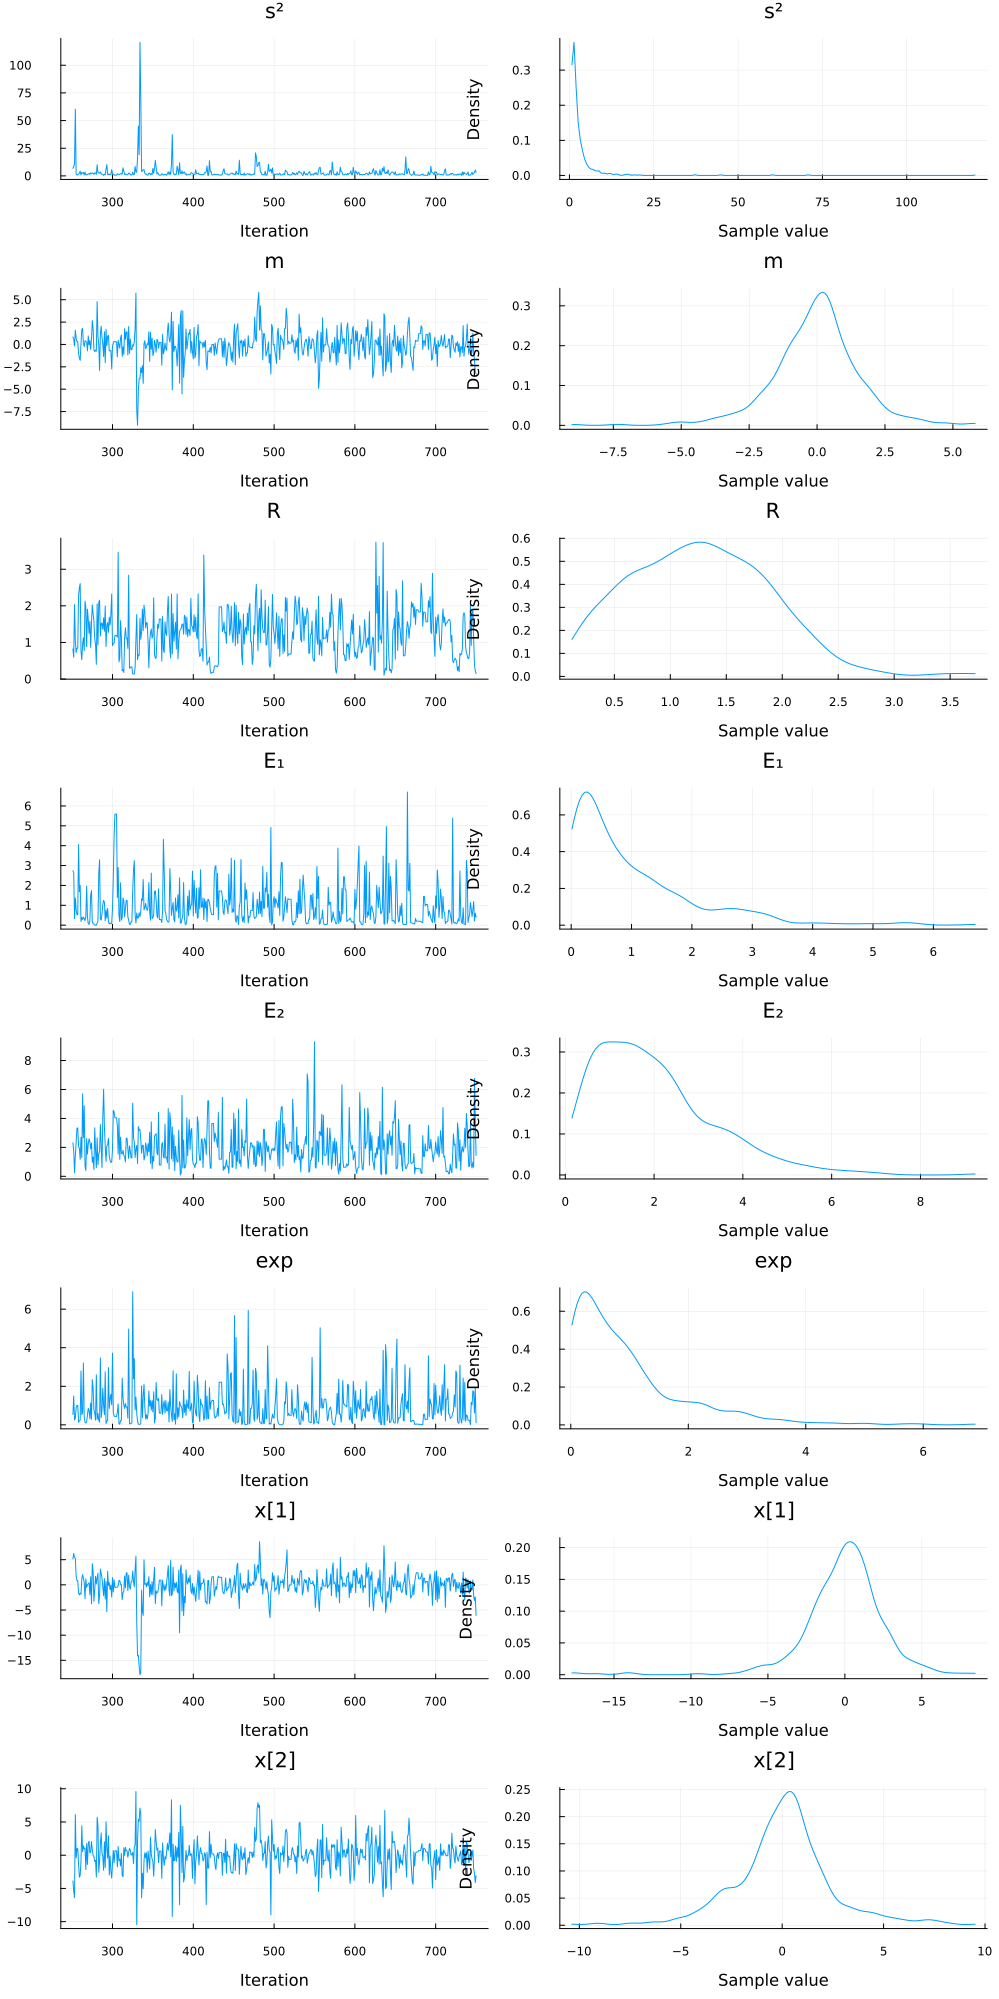

In [5]:
plot(c)

In [6]:
using Optim

In [9]:
argmax = maximum(mle.values)

3.0007827352651497

##### 💡 MLE - related references
- [ ] [The function fit_mle is for maximum likelihood estimation.](https://juliastats.org/Distributions.jl/stable/fit/#Maximum-Likelihood-Estimation)
- [ ] [A demonstration of doing maximum likelihood estimation using Julia](https://mmmlab.rbind.io/posts/2021-03-09-julia-mle/)

In this case, because we use the [normal-inverse gamma distribution](https://en.wikipedia.org/wiki/Normal-inverse-gamma_distribution) as a [conjugate prior](https://en.wikipedia.org/wiki/Conjugate_prior), we can compute its updated mean as follows:

In [10]:
s² = InverseGamma(2, 3)
m = Normal(0, 1)
data = [1.5, 2]
x_bar = mean(data)
N = length(data)

mean_exp = (m.σ * m.μ + N * x_bar) / (m.σ + N)

1.1666666666666667

We can also compute the updated variance

In [11]:
updated_alpha = shape(s²) + (N / 2)
updated_beta =
    scale(s²) +
    (1 / 2) * sum((data[n] - x_bar)^2 for n in 1:N) +
    (N * m.σ) / (N + m.σ) * ((x_bar)^2) / 2
variance_exp = updated_beta / (updated_alpha - 1)

2.0416666666666665

Finally, we can check if these expectations align with our HMC approximations from earlier. We can compute samples from a normal-inverse gamma following the equations given [here](https://en.wikipedia.org/wiki/Normal-inverse-gamma_distribution#Generating_normal-inverse-gamma_random_variates).

In [12]:
function sample_posterior(alpha, beta, mean, lambda, iterations)
    samples = []
    for i in 1:iterations
        sample_variance = rand(InverseGamma(alpha, beta), 1)
        sample_x = rand(Normal(mean, sqrt(sample_variance[1]) / lambda), 1)
        samples = append!(samples, sample_x)

        # TO DO - Add the other distributions
        # R ~ Rayleigh()
        # E₁ ~ Erlang(1)
        # E₂ ~ Erlang(2)
        # E₃ ~ Erlang(3)
    end
    return samples
end

analytical_samples = sample_posterior(updated_alpha, updated_beta, mean_exp, 2, 1000);

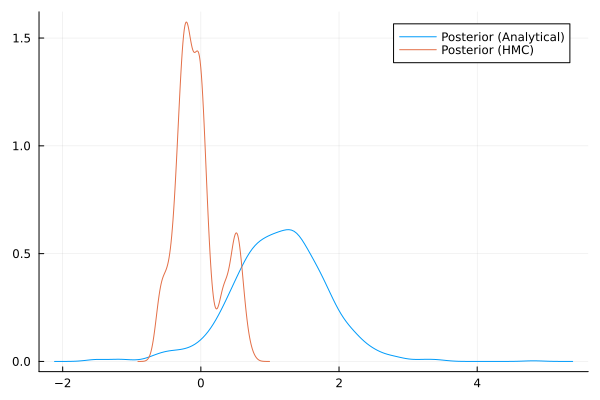

In [13]:
density(analytical_samples; label="Posterior (Analytical)")
density!(c[:m]; label="Posterior (HMC)")

# References

- [ ] [Using Turing: Getting Started](https://turinglang.org/v0.29/docs/using-turing/get-started)
- [ ] [Some question about the structure of Turing models](https://discourse.julialang.org/t/some-question-about-the-structure-of-turing-models/48211/17)
- [ ] [Model building of golf putting with Turing.jl](https://jduncstats.com/posts/2019-11-02-golf-turing/)
- [ ] [Rayleigh Distribution - Generating a Random Sample with Inverse Transforms Sampling](https://www.youtube.com/watch?v=GVphZq7Siro)
- [ ] [A comparison of common distributions in Julia, Python and R](https://discourse.julialang.org/t/a-comparison-of-common-distributions-in-julia-python-and-r)
- [ ] [Parameter estimation of a Rayleigh random variable with an offset](https://stats.stackexchange.com/questions/224416/parameter-estimation-of-a-rayleigh-random-variable-with-an-offset)
- [ ] [Maximum Likelihood Estimation with Julia](https://mmmlab.rbind.io/posts/2021-03-09-julia-mle/)
- [ ] [ref_emoji](https://www.w3schools.com/charsets/ref_emoji.asp)
- [ ] [How to Easily Insert Emoji in the Jupyter Notebook](https://medium.com/@shouke.wei/how-to-easily-insert-emoji-in-the-jupyter-notebook-36a1b77c0cb4)
   
<p>Hex: x2705 I will display &#x2705;</p>


- [ ] Julia Help Exponential
```julia
help?> Exponential
```
search: Exponential ExponentialBackOff DoubleExponential SkewedExponentialPower exponent

  Exponential(θ)

  The Exponential distribution with scale parameter θ has probability density function

  $$f(x; \theta) = \frac{1}{\theta} e^{-\frac{x}{\theta}}, \quad x > 0$$

```julia
  Exponential()      # Exponential distribution with unit scale, i.e. Exponential(1)
  Exponential(θ)     # Exponential distribution with scale θ
  
  params(d)          # Get the parameters, i.e. (θ,)
  scale(d)           # Get the scale parameter, i.e. θ
  rate(d)            # Get the rate parameter, i.e. 1 / θ
```

  External links

    •  Exponential distribution on Wikipedia (http://en.wikipedia.org/wiki/Exponential_distribution)

#### give few parametric continous distributions

Certainly! Parametric continuous distributions are characterized by a finite number of parameters that define their shape. Here are a few commonly used parametric distributions:

1. **Normal Distribution (Gaussian Distribution):**
   - Parameters: $$\text{Mean } (\mu) \text{, Standard deviation } (\sigma)$$
   - Probability Density Function (PDF): $$f(x|\mu, \sigma) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(x-\mu)^2}{2\sigma^2}\right)$$

2. **Uniform Distribution:**
   - Parameters: $$\text{Minimum } (a) \text{, Maximum } (b)$$
   - Probability Density Function (PDF): $$f(x|a, b) = \frac{1}{b-a} \text { for } a \leq x \leq b \text {, and 0 otherwise.}$$

3. **Exponential Distribution:**
   - Parameter: $$\text{ Rate parameter } (\lambda)$$
   - Probability Density Function (PDF): $$f(x|\lambda) = \lambda e^{-\lambda x}  \text { for }  x \geq 0 \text {, and 0 otherwise.}$$

4. **Gamma Distribution:**
   - Parameters: $$\text{ Shape parameter } (k) \text{,  Rate parameter } (\theta)$$
   - PDF: $$f(x|k, \theta) = \frac{1}{\Gamma(k)\theta^k} x^{k-1} e^{-\frac{x}{\theta}} \text { for }  x \geq 0 \text {, and 0 otherwise.}$$

5. **Beta Distribution:**
   - Parameters: $$\text{ Shape parameters } (\alpha, \beta)$$
   - PDF: $$f(x|\alpha, \beta) = \frac{x^{\alpha-1}(1-x)^{\beta-1}}{B(\alpha, \beta)} \text { for } 0 \leq x \leq 1 \text{ , where } B(\alpha, \beta) \text { is the Beta function. }$$

6. **Logistic Distribution:**
   - Parameters: $$\text{Location parameter } (\mu) \text{, Scale parameter } (s)$$
   - PDF: $$f(x|\mu, s) = \frac{e^{-(x-\mu)/s}}{s(1+e^{-(x-\mu)/s})^2}$$

7. **Cauchy Distribution:**
   - Parameters: $$\text{Location parameter } (x_0) \text{, Scale parameter } (\gamma)$$
   - PDF: $$f(x|x_0, \gamma) = \frac{1}{\pi\gamma \left[1 + \left(\frac{x - x_0}{\gamma}\right)^2\right]}$$

8. **Weibull Distribution:**
   - Parameters: $$\text{ Shape parameter } (k) \text{ , Scale parameter } (\lambda)$$
   - PDF: $$f(x|k, \lambda) = \frac{k}{\lambda}\left(\frac{x}{\lambda}\right)^{k-1} e^{-(x/\lambda)^k} \text { for }  x \geq 0 \text {, and 0 otherwise.}$$

9. **Gamma Distribution:**
   - Parameters: $$\text{ Shape parameter } (k) \text{,  Rate parameter } (\theta)$$
   - PDF: $$f(x|k, \theta) = \frac{1}{\Gamma(k)\theta^k} x^{k-1} e^{-\frac{x}{\theta}} \text { for }  x \geq 0 \text {, and 0 otherwise.}$$


These are continuous distributions commonly used in various fields for modeling different types of data. Each distribution has its own characteristics and is suitable for different scenarios based on the properties of the data being modeled.
These are just a few examples, and there are many other parametric distributions used in statistics and probability theory depending on the characteristics of the data being modeled.

$$f(x; \theta) = \frac{1}{\theta} e^{-\frac{x}{\theta}}, \quad x > 0$$

  $$f(y; \sigma) = \frac{y}{\sigma^2} e^{-\frac{y^2}{2 \sigma^2}}, \quad x > 0$$